In [1]:
# standard python modules
import numpy as np
import time
import copy

# plotting utilities
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

get_ipython().run_line_magic('matplotlib', 'inline')
cmap = mpl.cm.inferno;mpl.rcParams['xtick.labelsize'] = 12;
mpl.rcParams['ytick.labelsize'] = 12;
mpl.rcParams['font.weight'] = 'medium';
mpl.rcParams['axes.linewidth'] = 1.5;
mpl.rcParams['xtick.major.width'] = 1.5;
mpl.rcParams['xtick.minor.width'] = 0.75;
mpl.rcParams['xtick.minor.visible'] = True;
mpl.rcParams['ytick.major.width'] = 1.5;
mpl.rcParams['ytick.minor.width'] = 0.75;
mpl.rcParams['ytick.minor.visible'] = True


# SCF coefficients. 
import sys
sys.path.append('../scf_coefficients/')
import scf_utils

### 1. The first ingredient is some prescription to _embed_ the data. At this step, we are creating a trajectory matrix that is comprised of _lagged_ copies of the input data stream. This constructs a matrix where the antidiagonals have the same value. We will call this matrix $T$, following WP21, equation 10.


In [2]:
def embed_data(data,L,K,ndim=1,norm=False):
    """
    Build embedded time series, Y.
    Follows the embedding strategy of Weinberg \& Petersen (2021)
    Augmented vectors are the rows.
    
    inputs
    ---------
    data     : (array) data streams, set up as data[0],data[1],data[2]...
    L        : (int) the window length
    K        : (int) the length of augmented vectors
    ndim     : (int, default 1) number of data streams to consider
    norm     : (bool, default False) detrend the data?
    
    returns
    ---------
    Y        : (array) the trajectory matrix
    """
    Y = np.zeros([L,K*ndim])
    N = np.zeros(ndim)
    Sigma = np.zeros(ndim)
    
    for n in range(0,ndim):
        N[n] = np.nanmean(data[n])
        Sigma[n] = np.nanstd(data[n])
        for j in range(0,K):
            for i in range(0,L):
                if norm:
                    Y[i, K*n+j] = (data[n][i + j] - np.nanmean(data[n]))/np.nanstd(data[n])
                else:
                    Y[i, K*n+j] = data[n][i + j] 
    print('Shape of Y:',Y.shape)
    if norm == False:
        return Y
    elif norm == True:
        return Y, N, Sigma


The second step is to construct the lag-covariance matrix. We have two choices here:
 1. Reconstruct the full dimensionality, $C = \frac{1}{K}T^T\cdot T$, where the matrix is $K\times K$.
 2. Reconstruct the reduced dimensionality, $C = \frac{1}{K}T\cdot T^T$, where the matrix is $L\times L$.
 
 We will here choose option 1, but will note the differences below. This is equation 11 in WP21.



In [3]:
def make_covariance(Y,K,full=True):
    """
    estimate the covariance matrix C_X, using the formula in eq 9
    
    inputs
    ---------
    Y     : (array) the trajectory matrix
    K     : (array) the length of the augmented vectors
    
    returns
    ---------
    C     : (array) the covariance matrix
    
    """
    if full:
        C = np.dot(Y.T,Y)/K
    else:
        C = np.dot(Y,Y.T)/K
    print('C shape:',C.shape)
    return C





Now we get to the magic: making the principal components, singular vectors, and empirical orthogonal functions. This is accomplished by a singular value decomposition step.
 
Following equation 12 of WP21, use SVD: $$C = U\cdot \Lambda \cdot V.$$ SVD takes as an input $C$ and returns $U$, $\Lambda$, and $V$. The columns of $U$ are the eigenvectors (or empirical orthogonal functions EOF, $L$ with length $K$), which we immediately use to construct the principal components (with length $K$) by projecting the time series onto the EOF: $$P = Y\cdot U.$$
 

Other notes:
 1. $\Lambda$ are the singular values. These are typicall ordered largest to smallest by SVD algorithms.
 2. $U = V^T$, to SVD approximation precision.



In [4]:
def make_pcs(C,Y,ndim=1):
    """perform the SVD on the covariance matrix to construct the PCs.
    
    inputs
    ---------
    C     : (array) the covariance matrix   
    Y     : (array) the trajectory matrix
    ndim  : (int, default 1) the number of MSSA dimensions
    
    returns
    ---------
    PCs   : (array) the principal components (in rows)
    U     : (array)
    S     : (vector) the list of singular vectors
    
    
    
    """
    U,SV,V = np.linalg.svd(C, full_matrices=True)
    
    #print(U.shape,SV.shape,V.shape)

    # the columns of U are the left singular vectors
    # the columns of V are the right singular vectors
    # SV are the singular values
    
    # to recover the PCs, dot the trajectory matrix and the left singular vectors
    # the projection of the time series Y onto the EOF (eigenvectors), U
    PCs = np.dot(Y,U)

    print('PC shape:',PCs.shape)
    print('Left singular vector shape:',U.shape)
    return PCs,U,SV




We aren't quite done yet: we want to reconstruct the contribution to the input time series from each PC. This is accomplished through an _antidiagonal average_ of the transformed PCs. In WP21, we explicitly write the element reconstruction; in this implementation we will play a numpy trick to accomplish the antidiagonal average:
1. Select the PC to use for reconstruction, $P$, and the corresponding EOF, $E$.
2. Calculate $A = P^T\cdot E$.
3. Compute the antiagonal average of $A$ by reversing the matrix and using numpy's built in .diagonal call to compute the average.
$E$ is a column of $U$. 


In [5]:
def reconstruct(PC,EOF,pcnum,K,nd=1):
    """Average antidiagonal elements of a 2d array
    
    inputs
    -----------
    PC    : (array) PCs
    EOF   : (array) empirical orthogonal functions
    pcnum : (int) which PC to consider
    K     : (int) length of the augmented vectors
    ndim  : (int, default 0) which MSSA dimension to consider

    returns
    -------
    x1d   : (np.array) 1d numpy array representing averaged antidiangonal elements of A

    thanks to: https://codereview.stackexchange.com/questions/195635/numpy-2d-array-anti-diagonal-averaging
    """
    A = np.dot(np.array([PC[:,pcnum]]).T,np.array([EOF[K*nd:K*(nd+1),pcnum]]))
    
    x1d = [np.mean(A[::-1, :].diagonal(i)) for i in range(-A.shape[0] + 1, A.shape[1])]

    return np.array(x1d)




This is a good time to introduce a tool for interpretation: the $w$-correlation matrix. We won't go in to the calculation details -- see WP21 eq 19 -- but the $w$-correlation matrix tries to find similarity between PCs, which often indicate that they are a group.


In [6]:
def wCorr(R):
    """
    make the w-correlation matrix.
    
    inputs
    --------
    R     : (array) the reconstructed elements, stacked.
    
    returns
    -----------
    wcorr : (array) the w-correlation matrix
    """
    
    numT   = R.shape[0]
    numW   = R.shape[1]
    Lstar  = np.nanmin([numT - numW, numW]);
    Kstar  = np.nanmax([numT - numW, numW]);

    wcorr = np.zeros([numW, numW])
    for m in range(0,numW):
        for n in range(m,numW):
            for i in range(0,numT):
                if   (i < Lstar): w = i;
                elif (i < Kstar): w = Lstar;
                else            : w = numT - i + 1;
                
                wcorr[m, n] += w * R[i, m]*R[i, n];

    #// Normalize
    for m in range(0,numW):
        for n in range(m+1,numW):
            if (wcorr[m, m]>0.0 and wcorr[n, n]>0.0):
                wcorr[m, n] /= np.sqrt(wcorr[m, m]*wcorr[n, n]);


    #// Unit diagonal
    for m in range(0,numW): 
        wcorr[m, m] = 1.0;

    #// Complete
    for m in range(0,numW):
        for n in range(0,m):
            wcorr[m, n] = wcorr[n, m];

    return wcorr;




In [7]:
coeff_filename = "../../data/expansion/MWLMC5_snap_1e6/BFE_MWLMC5_grav_MO5_ss_COM_n20_20_nsamp_1e6_host_snap_"
S_coefficients, T_coefficients, Svar, Tvar, STvar, rcom, exp_params = scf_utils.array_coefficients(coeff_filename, 0, 400)

In [8]:
np.shape(T_coefficients)

(400, 21, 21, 21)

In [9]:
nfinal=400
S00 = S_coefficients[:nfinal,0,0,0]
T00 = T_coefficients[:nfinal,0,0,0]

S10 = S_coefficients[:nfinal,0,1,0]
S11 = S_coefficients[:nfinal,0,1,1]
S11 = S_coefficients[:nfinal,0,1,1]
T10 = T_coefficients[:nfinal,0,1,0]
S20 = S_coefficients[:nfinal,0,2,0]

T20 = T_coefficients[:nfinal,0,2,0]

S30 = S_coefficients[:nfinal,0,3,0]
T30 = T_coefficients[:nfinal,0,3,0]

S40 = S_coefficients[:nfinal,0,4,0]
S50 = S_coefficients[:nfinal,0,5,0]
S60 = S_coefficients[:nfinal,0,6,0]
S70 = S_coefficients[:nfinal,0,7,0]
S80 = S_coefficients[:nfinal,0,8,0]


# to detrne multiply by th variance and divide by the mean

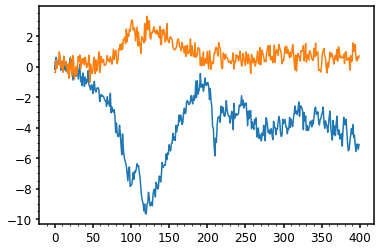

In [34]:
plt.plot(S_coefficients[:,0,2,2])
plt.plot(T_coefficients[:,0,2,2])

In [10]:
# only do the expensive steps once!!


ndim = 8   # as this is SSA, we only have one dimension of data
N    = nfinal # set the length of the data


data = np.zeros([ndim,N])
data[0] = S10
data[1] = S20
data[2] = S30
data[3] = S40
data[4] = S50
data[5] = S60
data[6] = S70
data[7] = S80



L = 200   # set the window length
K = N-L+1 # calculate the length of the lagged series
Y, Norm, Sigma = embed_data(data,L,K,ndim, norm=True)
C = make_covariance(Y,K)  # not aware of dimensions

Shape of Y: (200, 1608)
C shape: (1608, 1608)


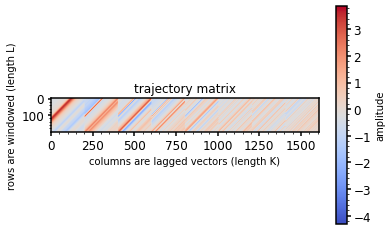

In [11]:
plt.figure()
plt.imshow(Y,cmap=cm.coolwarm)
plt.title('trajectory matrix')
plt.colorbar(label='amplitude')
plt.ylabel('rows are windowed (length L)')
_ = plt.xlabel('columns are lagged vectors (length K)')

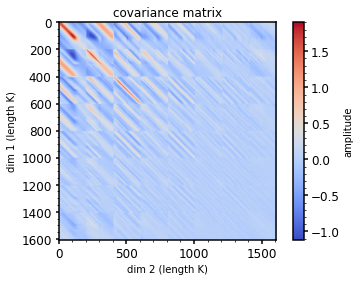

In [12]:
plt.figure()
plt.imshow(C,cmap=cm.coolwarm)
plt.title('covariance matrix')
plt.colorbar(label='amplitude')
plt.ylabel('dim 1 (length K)')
_ = plt.xlabel('dim 2 (length K)') 

In [13]:
# ### Example 8
# 
# What about the correlation of $m=1$ and $m=2$?

# In[ ]:


# bring in some processed data. columns are
# 0: time
# 1-2: m=1, n=0
# 3-4: m=2, n=0
# 5-6: m=1, n=1
# ...etc



        
#data[1] = S10
#data[2] = S20
#data[3] = S30

#plt.figure(figsize=(5,3))
#plt.plot(data[0],color='black',lw=1.)
#plt.plot(data[1],color='blue',lw=1.)
#plt.title('input data series')
#plt.ylabel('amplitude')
#_ = plt.xlabel('sample number (N)')


# In[ ]:




PC,EOF,SV = make_pcs(C,Y) # not aware of dimensions




# Okay, that last one was painful -- we need production MSSA!
# 
# See Alex's code, which we are finishing the user interface for.

PC shape: (200, 1608)
Left singular vector shape: (1608, 1608)


Text(0, 0.5, 'amplitude')

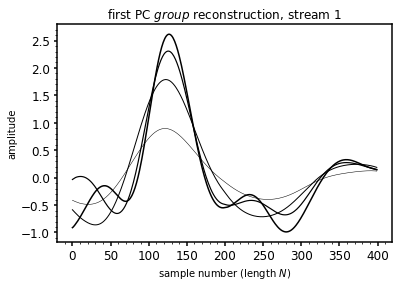

In [14]:
# In[ ]:


# pick the dimension to reconstruct
reconstruct_stream = 0
O = reconstruct(PC,EOF,0,K,reconstruct_stream)
O1 = reconstruct(PC,EOF,1,K,reconstruct_stream)
O2 = reconstruct(PC,EOF,2,K,reconstruct_stream)
O3 = reconstruct(PC,EOF,3,K,reconstruct_stream)
O4 = reconstruct(PC,EOF,4,K,reconstruct_stream)
O5 = reconstruct(PC,EOF,5,K,reconstruct_stream)
O6 = reconstruct(PC,EOF,6,K,reconstruct_stream)
O7 = reconstruct(PC,EOF,7,K,reconstruct_stream)
O8 = reconstruct(PC,EOF,8,K,reconstruct_stream)


plt.figure()
plt.plot(O,color='black', lw=0.5)
plt.plot(O+O1,color='black', lw=1.0)
plt.plot(O+O1+O2,color='black', lw=1.2)
plt.plot(O+O1+O2+O3,color='black', lw=1.5)

#plt.plot(data[reconstruct_stream],color='grey',linestyle='dashed')
plt.title('first PC $group$ reconstruction, stream 1')
plt.xlabel('sample number (length $N$)')
plt.ylabel('amplitude')


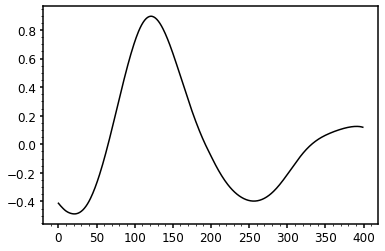

In [15]:
plt.plot(O,color='black')

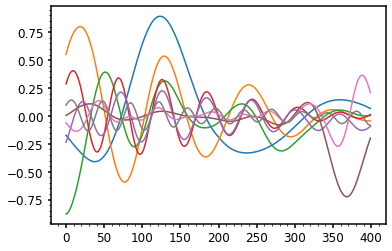

In [16]:
plt.plot(O1)
plt.plot(O2)
plt.plot(O3)
plt.plot(O4)
plt.plot(O5)
plt.plot(O6)
plt.plot(O7)
plt.plot(O8)

(-2.0, 100.0)

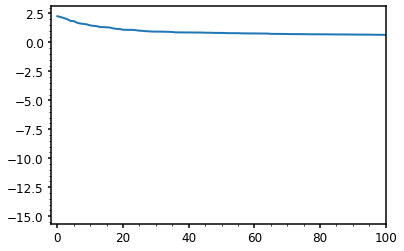

In [17]:
plt.plot(np.log10(np.abs(SV)), lw=2)
plt.xlim(-2, 100)

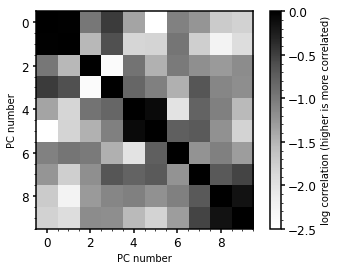

In [18]:
# select a maximum PC to consider
pcmax = 10

# build a reconstruction matrix (PC contributions stacked on top of one another)
RC = np.zeros([N,pcmax])
for i in range(0,pcmax):
    RC[:,i] = reconstruct(PC,EOF,i,K,nd=0)
    
# compute the w-correlation matrix
R = wCorr(RC)

plt.imshow(np.log10(np.abs(R)),cmap=cm.Greys, vmax=0, vmin=-2.5)
plt.colorbar(label='log correlation (higher is more correlated)')
plt.xlabel('PC number')
_ = plt.ylabel('PC number')


In [19]:
# Visualize fields

In [20]:
print(np.shape(Sigma), np.shape(Norm))

(8,) (8,)


# Reversing detrend

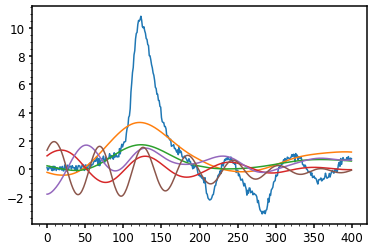

In [21]:
plt.plot(S10)
plt.plot(O*Sigma[0]+Norm[0])
plt.plot(O1*Sigma[1]+Norm[1])
plt.plot(O2*Sigma[2]+Norm[2])
plt.plot(O3*Sigma[3]+Norm[3])
plt.plot(O4*Sigma[4]+Norm[4])



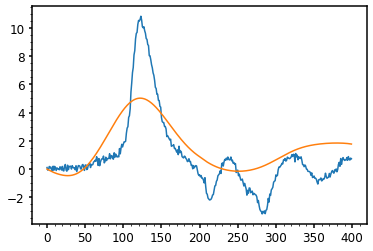

In [22]:
plt.plot(S10)
plt.plot(O*Sigma[0]+Norm[0] + O1*Sigma[1]+Norm[1] )


# Visualizing fields

In [23]:
import sys
sys.path.append('../check_expansion/')
from check_expansion import density_contour

In [24]:
np.shape(S_coefficients[0])

(21, 21, 21)

In [25]:
exp_params

[array(40.85), array(0.00013473, dtype=float32), array(0)]

In [27]:
S_reconstruct = np.zeros([5, 5, 5])
T_reconstruct = np.zeros_like(S_reconstruct) 

for t in range(400):
    #S_reconstruct[0,0,0] = S00[t]
    S_reconstruct[0,3,0] = (O2[t]*Sigma[2])+Norm[2]
    S_reconstruct[0,4,0] = (O3[t]*Sigma[3])+Norm[3] 
    density_contour(S_reconstruct, T_reconstruct, [-300, 300], 1E10, exp_params[0], snap=t, delta_rho=False, figname='PC2_density_contour')

In [35]:
## Reading Mike's coefficients


In [40]:
# index 

np.shape(MW)

(1301, 73)

In [ ]:
MW = np.genfromtxt('../../data/mikes/LilleengenMW.txt')


In [48]:
tmax = len(MW[:,0])
nmax = 8
lmax = 3
mmax = 3
ncolumns = nmax*lmax*mmax + 1 # + 1 is time

In [105]:
def reading_exp_halo(coefficients, tmax, nmax, lmax, mmax):
    """
    Following EXP format: ###
    columns 
    t, l=0 m=0 n=0,  l=0, m=0, n=1 ... l=1, m=0,
    3*8*3
    """
    Ajnlm_sin = np.zeros((tmax, nmax, lmax, mmax))
    Ajnlm_cos = np.zeros((tmax, nmax, lmax, mmax))
    for t in range(tmax):
        columns=1
        for n in range(0, nmax):
            for l in range(lmax):
                for m in range(l+1):
                    if m==0:
                        Ajnlm_cos[t, n, l, m] = coefficients[t,columns]
                        columns+=1
                    if m>0:
                        Ajnlm_cos[t, n, l, m] = coefficients[t,columns]
                        columns+=1
                        Ajnlm_sin[t, n, l, m] = coefficients[t,columns]
                        columns+=1
    return Ajnlm_cos, Ajnlm_sin

In [106]:
Amw_exp_cos, Amw_exp_sin = reading_exp_halo(MW, tmax, nmax, lmax, mmax)

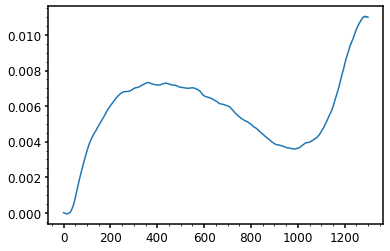

In [110]:
plt.plot(Amw_exp_cos[:,0,0,0]/Amw_exp_cos[0,0,0,0] -1)

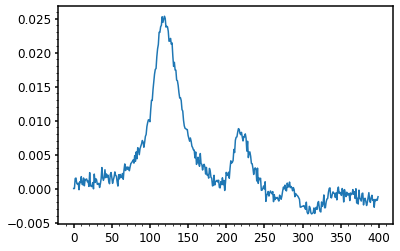

In [112]:
plt.plot(S_coefficients[:,0,0,0]/S_coefficients[0,0,0,0]-1)

In [ ]:
for c in len(ncolumns):
    
    Ajnlm[0,:,0,0] = MW[:,ncolumns]

In [43]:
# the first column is time (virial units, so T=1 is 2Gyr, pericentre is ~1.2)
nmax = 8 # retaining the first 8 radial orders #max for mw is 18 lmax=6, mmax=6 
nval = 0 # select which n order you are interested in
lval=3
stride = 4 # subsample the time, if you want (there are 1301 total outputs here)
inputlength = MW[::stride,nmax*lval+nval].size
ndim = 3
data = np.zeros([ndim,inputlength])

# using lval, which is interleaved harmonic orders, select the relevant data streams
lval=1;data[0] = MW[::stride,nmax*lval+nval+1]
lval=2;data[1] = MW[::stride,nmax*lval+nval+1]
lval=3;data[2] = MW[::stride,nmax*lval+nval+1]

# TODO:

1. visualize fields [done]
2. Noise 
3. Correaltion between coefficients
4. Make a visualization of a PC as a function of time [done]
5. Read Mike's coefficients [done]

How to know 3. above
- Look at how much a PC contribute to a particuar set of coefficients. 
- When reconstructing a coeffiicent from the PC into a particuar coefficient. 
- take the rms of how each pc contribute to a given coefficient

# Ideas from beefy team

- Martin: Modify the correltion matrix W without normalizing

- KVJ: correlation with orbit could be done too and any time-series. 

- Alex J: look at correlation between coefficients in FFTs and grouping coefficients.  Grouping by power spectrum. Grouping by correlation matrix (W). 

- Alex J: It is a good practice ti use different strategies for grouping since some of them would owrk better depending on te problem you are interested.  